In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import cv2

In [2]:

label_map = {'black_bear': 0, 'people': 1, 'birds': 2, 'dog': 3, 'brown_bear': 4, 'roe_deer': 5, 'wild_boar': 6, 'amur_tiger': 7, 'amur_leopard': 8, 'sika_deer': 9}
target_size = (224,224)

transforms = v2.Compose([
    v2.RandomResizedCrop(size=target_size, antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
class RussianWildlifeDataset(Dataset):

    def __init__(self, img_dir):

        self.img_dir = img_dir
        self.data_list = []
        for label in os.listdir(self.img_dir):
            for file in os.listdir(os.path.join(self.img_dir,label)):
                self.data_list.append((file,label))

    def __len__(self):

        return len(self.data_list)

    def __getitem__(self, idx):

        file_name, label = self.data_list[idx]
        img_path = os.path.join(self.img_dir, label, file_name)

        img = torch.from_numpy(cv2.imread(img_path))
        img = img.permute(2, 0, 1)
        img = img/255
        img = transforms(img)
        return img.float(), label_map[label]

In [4]:
data = RussianWildlifeDataset('data')
print(len(data))

12825


In [5]:
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_set, val_set, test_set = random_split(data, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

print(len(train_set), len(val_set), len(test_set))

8977 1282 2566


In [6]:
import wandb

wandb.login()
wandb.init(
    project="cv_ass1", 
    name=f"Q2_CNN_AUG", 
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Russian Wildlife Dataset",
    "epochs": 10,
    })

config = wandb.config   

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: utsav21108 (utsv-grg). Use `wandb login --relogin` to force relogin


In [7]:
import torch
import torch.nn as nn

class CNN(nn.Module):
  
  def __init__(self, num_classes):

    super(CNN, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=4, stride=4)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.flatten = nn.Flatten()
    self.fc = nn.Linear(25088, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(10) # Assuming 10 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [9]:
n_epoch = config.epochs
save_loss = 99999

print("Started Training")

for epoch in range(n_epoch):
    print('Training for epoch: ', epoch)

    model.train()
    tloss = 0
    tstep = 0

    for i, data in enumerate(train_loader, 0):
        img, label = data
        inputs = img.to(device)
        labels = label.to(device)
        optimizer.zero_grad()

        inputs = inputs.squeeze(1)
        outputs = model(inputs)

        train_loss =  criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()
        tstep+=1
        tloss += train_loss.item()

    tstep+=1
    print('EPOCH:',epoch)
    print('Average train loss:', tloss/tstep)

    model.eval()
    vloss = 0
    vstep = 0

    for i, data in enumerate(val_loader, 0):
        img, label = data
        inputs = img.to(device)
        labels = label.to(device)

        inputs = inputs.squeeze(1)
        outputs = model(inputs)

        val_loss =  criterion(outputs, labels)
        vstep+=1
        vloss += val_loss.item()

    vstep+=1
    print('EPOCH:',epoch)
    print('Average val loss:', vloss/vstep)
    if(vloss/vstep<save_loss):
        save_loss = vloss/vstep
        state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(state, 'q2_cnn_aug_best.pt')  

    log_metric = {"Epoch":epoch, "Train Loss": tloss/tstep, "Val Loss": vloss/vstep}
    wandb.log(log_metric)
        
print("Finished Training")

Started Training
Training for epoch:  0
EPOCH: 0
Average train loss: 2.069390412763501
EPOCH: 0
Average val loss: 1.8633783573196048
Training for epoch:  1
EPOCH: 1
Average train loss: 1.8511972144140418
EPOCH: 1
Average val loss: 1.721048803556533
Training for epoch:  2
EPOCH: 2
Average train loss: 1.7062070107629113
EPOCH: 2
Average val loss: 1.5579820956502641
Training for epoch:  3
EPOCH: 3
Average train loss: 1.6200160878769896
EPOCH: 3
Average val loss: 1.5205740815117246
Training for epoch:  4
EPOCH: 4
Average train loss: 1.5514198503595718
EPOCH: 4
Average val loss: 1.5481050411860149
Training for epoch:  5
EPOCH: 5
Average train loss: 1.4719773197004982
EPOCH: 5
Average val loss: 1.3769831543877011
Training for epoch:  6
EPOCH: 6
Average train loss: 1.4088380347329674
EPOCH: 6
Average val loss: 1.3600028923579626
Training for epoch:  7
EPOCH: 7
Average train loss: 1.3842791424575427
EPOCH: 7
Average val loss: 1.467344548021044
Training for epoch:  8
EPOCH: 8
Average train loss

In [10]:
state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(state, 'q2_cnn_aug.pt')

The train loss keeps on reducing on training after each epoch which is expected. And because we have introduced data augmentation the overfitting is stopped. The val decreases continously.
One can also see the train loss is also reducing slowly then without augmentation as it sees more of new training data.
Actually it is underfitted and can see more training epochs

In [11]:
#In case best model is to be runned.
# model = CNN(10)
# state_dict = torch.load('q2_cnn_best.pt')
# model.load_state_dict(state_dict['model'])

In [12]:
print("Started Testing")

test_labels = []
test_predictions = []

model.eval()

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        img, labels = data
        test_labels.extend(labels.numpy())

        inputs = img.to(device)
        inputs = inputs.squeeze(1)
        
        outputs = model(inputs).argmax(dim=1)
        test_predictions.extend(outputs.numpy())
        
print("Finished Testing")

Started Testing
Finished Testing


In [13]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)


correct = (test_labels==test_predictions).sum()
total = len(test_predictions)

acc = correct/total
f1score = f1_score(test_labels,test_predictions,average='macro')

print("Accuracy: ", acc)
print("F1 Score: ", f1score)

cm = confusion_matrix(test_labels, test_predictions)
wandb.log({"Accuracy":acc, "F1 Score":f1score})
print(cm)

Accuracy:  0.5354637568199533
F1 Score:  0.5359180307504628
[[ 94   3   1   8  60   7  12   0   1  16]
 [  4 187  15  17  11  12   2   5   4  16]
 [  5  33 205  20  23  12  12   4  16  11]
 [ 18  16  22  76  19  29  13  12   5  57]
 [ 44   9   3   6 125  26  15   1   1  11]
 [  7  10   5  10  14 134   5   4   1  50]
 [ 37   5   8  13  50  27 162   1   9  13]
 [  7   5  12   4   4  20   1 112  13  15]
 [  4   1  17   5   6  12   3  18 128   8]
 [ 12  21  17  11  18  35   8   7   2 151]]


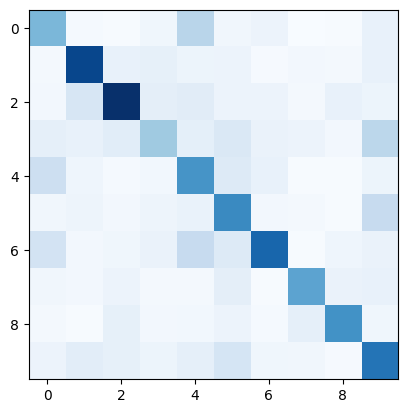

<Figure size 640x480 with 0 Axes>

In [14]:
plt.imshow(cm, cmap='Blues')
plt.show(plt)
wandb.log({"Confusion Matrix": wandb.Image(plt)})

In [15]:
wandb.finish()

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
F1 Score,▁
Train Loss,█▆▅▄▃▂▂▂▁▁
Val Loss,█▆▄▄▄▂▂▃▁▁
Accuracy,0.53546
Epoch,9
F1 Score,0.53592
Train Loss,1.32911
Val Loss,1.28544


In [17]:
n_epoch = config.epochs
save_loss = 99999

print("Started Training")

for epoch in range(n_epoch):
    print('Training for epoch: ', epoch)

    model.train()
    tloss = 0
    tstep = 0

    for i, data in enumerate(train_loader, 0):
        img, label = data
        inputs = img.to(device)
        labels = label.to(device)
        optimizer.zero_grad()

        inputs = inputs.squeeze(1)
        outputs = model(inputs)

        train_loss =  criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()
        tstep+=1
        tloss += train_loss.item()

    tstep+=1
    print('EPOCH:',epoch)
    print('Average train loss:', tloss/tstep)

    model.eval()
    vloss = 0
    vstep = 0

    for i, data in enumerate(val_loader, 0):
        img, label = data
        inputs = img.to(device)
        labels = label.to(device)

        inputs = inputs.squeeze(1)
        outputs = model(inputs)

        val_loss =  criterion(outputs, labels)
        vstep+=1
        vloss += val_loss.item()

    vstep+=1
    print('EPOCH:',epoch)
    print('Average val loss:', vloss/vstep)
    if(vloss/vstep<save_loss):
        save_loss = vloss/vstep
        state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(state, 'q2_cnn_aug_best.pt')  

    log_metric = {"Epoch":epoch, "Train Loss": tloss/tstep, "Val Loss": vloss/vstep}
    # wandb.log(log_metric)
        
print("Finished Training")

Started Training
Training for epoch:  0
EPOCH: 0
Average train loss: 1.2708142879584157
EPOCH: 0
Average val loss: 1.2571186820665996
Training for epoch:  1
EPOCH: 1
Average train loss: 1.2391011993935768
EPOCH: 1
Average val loss: 1.190423051516215
Training for epoch:  2
EPOCH: 2
Average train loss: 1.2146516780481271
EPOCH: 2
Average val loss: 1.22953865925471
Training for epoch:  3
EPOCH: 3
Average train loss: 1.194508287289464
EPOCH: 3
Average val loss: 1.1734989342235385
Training for epoch:  4
EPOCH: 4
Average train loss: 1.1858295062755018
EPOCH: 4
Average val loss: 1.1243872784432911
Training for epoch:  5
EPOCH: 5
Average train loss: 1.1477854262429772
EPOCH: 5
Average val loss: 1.1864720086256664
Training for epoch:  6
EPOCH: 6
Average train loss: 1.1530016189348613
EPOCH: 6
Average val loss: 1.2255755889983404
Training for epoch:  7
